In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import tensorflow as tf
print (tf.test.gpu_device_name())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/



# **Data Preprocessing**

In [2]:
import time
import calendar
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Feature Engineering**

In [0]:
# Find last Monday for holiday
def last_mon_date(year, month):
  """
  Returns a matrix representing a month’s calendar
  Each row represents a week; days outside of the month a represented by zeros
  Each week begins with Monday
  """
  cal = calendar.monthcalendar(year, month)
  last_mon_date = cal[4][0] if (cal[4][0] > 0) else cal[3][0]
  return str(year)+"-"+str(month)+"-"+str(last_mon_date)

def feature_engineering(df):
  
  df["time"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%m%d%Y %H:%M")) # Convert to timestamp from string 
  #df = df.set_index(["time"])

  df["Year"] = df["time"].apply(lambda x: x.year)
  df["Month"] = df["time"].apply(lambda x: x.month)
  df["Day"] = df["time"].apply(lambda x: x.day)
  df["Weekday"] = df["time"].apply(lambda x: x.weekday() + 1) # To adjust to 1 to 7 instead of 0 to 6
  df["Week"] = df["Day"].apply(lambda x: (x-1)//7+1)
  df["Weekend"] = df["Weekday"].apply(lambda x: 1 if x>=6 else 0) # Apply function to the column (default: axis=0)
  df["Hour"] = df["time"].apply(lambda x: x.hour)

  # Find last Monday in May
  unique_year = df["Year"].unique()
  last_mon_may = []
  for i in range(0, unique_year.shape[0], 1):
    last_mon_may.append(last_mon_date(unique_year[i], 5))
  last_mon_may = [time.mktime(datetime.datetime.strptime(x,"%Y-%m-%d").timetuple()) for x in last_mon_may] # Convert to timestamp

  df["Holiday"] = 0
  df["Holiday"] = df["time"].apply(lambda x: 1 if (datetime.datetime.timestamp(x) in last_mon_may) else 0)
  df["Holiday"].loc[(df["Month"] == 1) & (df["Day"] == 1)] = 1 # Remember () for condition
  df["Holiday"].loc[(df["Month"] == 12) & (df["Day"] == 25)] = 1
  df["Holiday"].loc[(df["Month"] == 11) & (df["Day"] == 11)] = 1
  df["Holiday"].loc[(df["Month"] == 7) & (df["Day"] == 4)] = 1
  df["Holiday"].loc[(df["Month"] == 1) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1
  df["Holiday"].loc[(df["Month"] == 2) & (df["Week"] == 3) & (df["Weekday"] == 1)] = 1 
  df["Holiday"].loc[(df["Month"] == 11) & (df["Week"] == 4) & (df["Weekday"] == 4)] = 1
  df["Holiday"].loc[(df["Month"] == 10) & (df["Week"] == 2) & (df["Weekday"] == 1)] = 1
  df["Holiday"].loc[(df["Month"] == 9) & (df["Week"] == 1) & (df["Weekday"] == 1)] = 1  

  df_sub = pd.get_dummies(df["Month"], drop_first=True, prefix="Month_")
  df_sub2 = pd.get_dummies(df["Weekday"], drop_first=True, prefix="Weekday_")
  df_sub3 = pd.get_dummies(df["Hour"], drop_first=True, prefix="Hour_")
  df = pd.concat([df, df_sub, df_sub2, df_sub3], axis=1)
  df = df.drop(["timestamp"], axis=1)

  return df

In [4]:
# os.listdir("/content/drive/My Drive/Colab/Research - EE5003")
df = pd.read_csv("/content/drive/My Drive/Colab/Research - EE5003/Final Modified Data_Rev2.csv")
df = feature_engineering(df)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,PV (kWh),Load (kWh),price (cents/kWh),time,Year,Month,Day,Weekday,Week,Weekend,Hour,Holiday,Month__2,Month__3,Month__4,Month__5,Month__6,Month__7,Month__8,Month__9,Month__10,Month__11,Month__12,Weekday__2,Weekday__3,Weekday__4,Weekday__5,Weekday__6,Weekday__7,Hour__1,Hour__2,Hour__3,Hour__4,Hour__5,Hour__6,Hour__7,Hour__8,Hour__9,Hour__10,Hour__11,Hour__12,Hour__13,Hour__14,Hour__15,Hour__16,Hour__17,Hour__18,Hour__19,Hour__20,Hour__21,Hour__22,Hour__23
0,0.0,2667.0,43.17,2011-01-01 00:00:00,2011,1,1,6,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,2525.0,36.24,2011-01-01 01:00:00,2011,1,1,6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,2417.0,34.64,2011-01-01 02:00:00,2011,1,1,6,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,2373.0,33.76,2011-01-01 03:00:00,2011,1,1,6,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,2374.0,33.08,2011-01-01 04:00:00,2011,1,1,6,1,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Visualization**

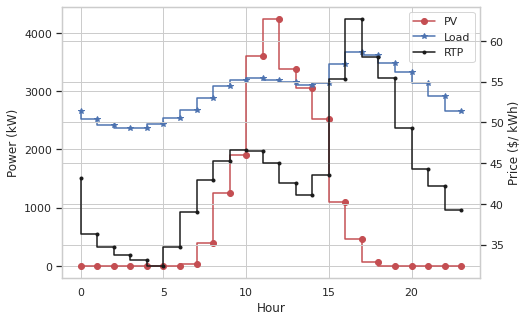

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax2 = ax.twinx()
PV_plot = ax.step(np.arange(24), df.iloc[0:24,0], 'ro-', label = "PV")
load_plot = ax.step(np.arange(24), df.iloc[0:24,1], 'b*-', label = "Load")
price_plot = ax2.step(np.arange(24), df.iloc[0:24,2], 'k.-', label = "RTP")

# Display all label in one box
plots = PV_plot + load_plot + price_plot
labels = [plot.get_label() for plot in plots]
ax.legend(plots, labels, loc = 0)
ax.set_xlabel("Hour")
ax.set_ylabel("Power (kW)")
ax2.set_ylabel("Price ($/ kWh)")

plt.show()

### **Normalization**

In [0]:
# MinMaxScaler = StandardScaler(with_mean = False)

# The mean is not shifted to zero-centered
sc_price = StandardScaler(with_mean=False)
price = sc_price.fit_transform(df.iloc[:,2:3].values)

sc_energy = StandardScaler(with_mean=False)
pv = sc_energy.fit_transform(df.iloc[:,0:1].values)
load = sc_energy.transform(df.iloc[:,1:2].values)

x = np.concatenate([pv, load, price], axis = -1)

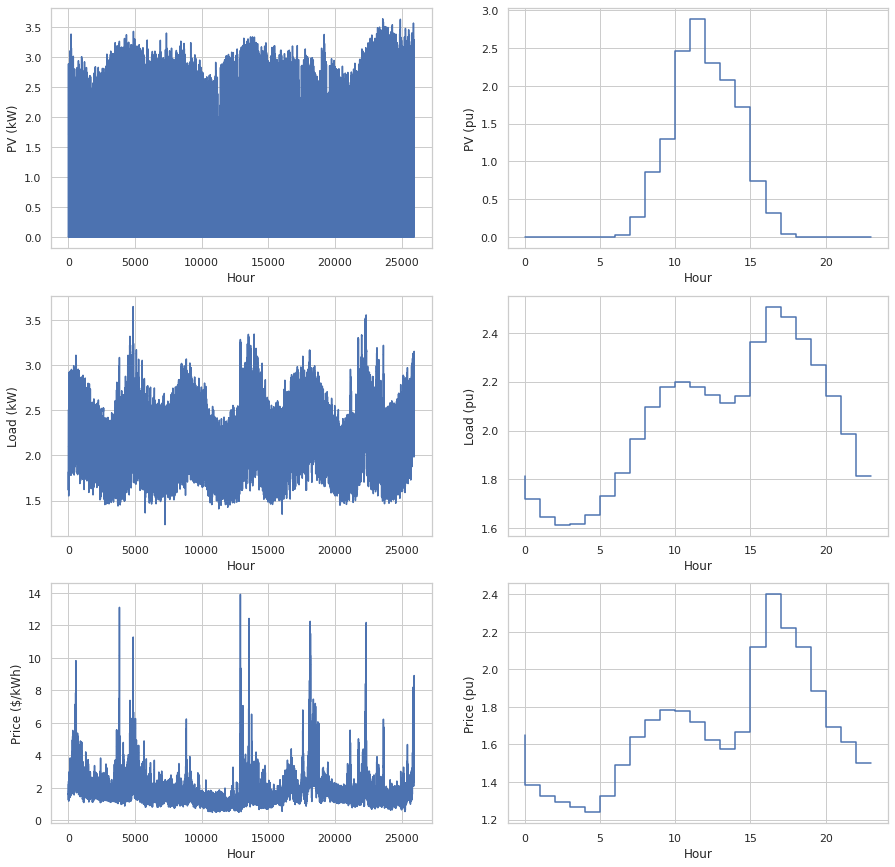

In [7]:
fig, ax = plt.subplots(3, 2, figsize = (15, 15))

ax[0, 0].step(np.arange(len(x[:,0])), x[:,0])
ax[0, 0].set_xlabel("Hour")
ax[0, 0].set_ylabel("PV (kW)")
ax[0, 1].step(np.arange(len(x[0:24,0])), x[0:24,0])
ax[0, 1].set_xlabel("Hour")
ax[0, 1].set_ylabel("PV (pu)")

ax[1, 0].step(np.arange(len(x[:,1])), x[:,1])
ax[1, 0].set_xlabel("Hour")
ax[1, 0].set_ylabel("Load (kW)")
ax[1, 1].step(np.arange(len(x[0:24,1])), x[0:24,1])
ax[1, 1].set_xlabel("Hour")
ax[1, 1].set_ylabel("Load (pu)")

ax[2, 0].step(np.arange(len(x[:,2])), x[:,2])
ax[2, 0].set_xlabel("Hour")
ax[2, 0].set_ylabel("Price ($/kWh)")
ax[2, 1].step(np.arange(len(x[0:24,2])), x[0:24,2])
ax[2, 1].set_xlabel("Hour")
ax[2, 1].set_ylabel("Price (pu)")

plt.show()

# **Model Predictive Control Linear Programming**

In [0]:
import pickle
import numpy as np
from scipy.optimize import linprog

In [0]:
class Battery():
    
  def __init__(self, scaler_energy, scaler_price):
    """
    P_rated - charge/ discharge rate (kW)
    E_rated - rated capacity (kWh)
    C_E - energy capital cost ($/kWh)
    LC - life cycle
    eta - efficiency
    DOD - depth of discharge
    wear_cost - wear & operation cost ($/kWh/operation)
    wear_cost = (C_E * E_rated) / (eta * E_rated * LC * DOD)

    As rated power smaller than rated energy, initial SOC is set to be maximumly 
    rated power away from the rated energy, if not LP does not work as constraint 
    violated --> rated_power / rated_energy + initial SOC < target SOC
    """ 
    
    self.P_rated = scaler_energy.transform(np.array([[1000]]))[0] # pu
    self.E_rated = scaler_energy.transform(np.array([[5000]]))[0] # pu 
    self.C_E = scaler_price.transform(np.array([[171]]))[0] # pu
    self.LC = 4996
    self.eta = 1.
    self.DOD = 1.
    self.wear_cost = self.C_E / self.eta / self.DOD / self.LC
    self.target_SOC = 0.5 # Decide the backup energy required
    self.initial_SOC = self.target_SOC 
    self.current_SOC = self.initial_SOC

  def update_SOC(self, action):
    self.current_SOC = self.current_SOC + action * self.P_rated / self.E_rated
    return self.current_SOC

In [0]:
"""
  1. x(t) - action at time t (within the range [-1, 1])
     p(t) - real time price at time t
     k - wear and tear cost of ESS
     P - per unit rated power of ESS
     E - per unit rated energy of ESS

     objective: minimize the transactive cost across the next 24 hours
                min (x1*(p1+k) + x2*(p2+k) + ... + x24*(p24+k))
     inequality constraint: operation limit - 0 <= x(t) * P / E + SOC(t) <= 1
     bounds: upper and lower bound of action [-1, 1]
     return: action of next 24 hours

  2. the actual ESS output power = action * P
  3. the SOC of ESS is updated after each hour and the linear programming optimization 
     is performed every hour with the updated data - model prediction control
"""

num_timesteps = 24
length = len(x) - num_timesteps + 1
battery = Battery(sc_energy, sc_price)
SOC_list = []
action_list = []

for i in range(length):

  pv = x[i:i+num_timesteps, 0]
  load = x[i:i+num_timesteps, 1]
  price = x[i:i+num_timesteps, 2]

  # coefficients of the linear objective function to be minimized
  # coefficients is normalized with load and pv such that 
  # ESS will react normally if there is no PV
  # ESS tend to store more PV when PV is much higher than load
  c = (price + battery.wear_cost) * load / (load + pv) * battery.P_rated

  # Inequality constraint - 0 <= x1 / E + SOC1 <= 1
  Aup = np.ones((24, 24)) * battery.P_rated / battery.E_rated 
  Aup = np.tril(Aup)
  Adown = np.flipud(Aup) * -1
  A = np.concatenate((Aup, Adown), axis=0) 
  bup = np.ones((24,)) - battery.current_SOC
  bdown = np.zeros((24,)) + battery.current_SOC - battery.target_SOC
  b = np.concatenate((bup, bdown), axis=0)

  # upper and lower bounds of the actions
  bounds = []
  for timestep in range(num_timesteps):
    bounds.append((-1, 1))

  # linear programming
  res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='revised simplex')
  actions = res.x

  # update SOC
  if i != (length - 1):
    SOC = battery.update_SOC(actions[0])
    SOC_list.append(SOC)
    action_list.append(actions[0])
  # for the last iteration
  else:
    for timestep in range(num_timesteps):
      SOC = battery.update_SOC(actions[timestep])
      SOC_list.append(SOC)
      action_list.append(actions[timestep]) 

  if i % 5000 == 0:
    print ("Computation at step {} completed".format(i))

Computation at step 0 completed
Computation at step 5000 completed
Computation at step 10000 completed
Computation at step 15000 completed
Computation at step 20000 completed
Computation at step 25000 completed


In [0]:
with open("/content/drive/My Drive/Colab/Research - EE5003/Phase 2 - Linear programming/result", "wb") as file:
  pickle.dump([SOC_list, action_list], file)

# **Result**

In [0]:
with open("/content/drive/My Drive/Colab/Research - EE5003/Phase 2 - Linear programming/result", "rb") as file:
  result = pickle.load(file)

SOC_list = result[0]
action_list = result[1]

In [0]:
SOC_bef_list = SOC_list.copy()
SOC_bef_list.insert(0, 0)
SOC_bef_list = SOC_bef_list[0:-1]

TRC_WOESS = 0
TRC_WESS = 0
OC_WESS = 0

for i in range(len(x)):
  
  # Without ESS  
  TRC_WOESS = TRC_WOESS - sc_price.inverse_transform(x[i:i+1, 2:3]) / 100 \
              * sc_energy.inverse_transform(x[i:i+1, 1:2] - x[i:i+1, 0:1])
  TC_WOESS = TRC_WOESS  
  
  # With ESS
  TRC_WESS = TRC_WESS - sc_price.inverse_transform(x[i:i+1, 2:3]) / 100\
             * sc_energy.inverse_transform(x[i:i+1, 1:2] - x[i:i+1, 0:1] \
             + np.expand_dims((np.array(SOC_list[i]) - np.array(SOC_bef_list[i])) * battery.P_rated, axis = -1))
  OC_WESS = OC_WESS - sc_price.inverse_transform(battery.wear_cost) \
             * sc_energy.inverse_transform(np.abs(np.expand_dims((np.array(SOC_list[i]) - np.array(SOC_bef_list[i])) * battery.P_rated, axis = -1)))
  TC_WESS = TRC_WESS + OC_WESS

print ("Cost without ESS: {:0.2f}".format(np.sum(TC_WOESS)))
print ("Cost with ESS: {:0.2f}".format(np.sum(TC_WESS)))
print ("Net benefit: {:0.2f}".format(np.sum(TC_WESS - TC_WOESS)))
print ("Daily mean cost without ESS: {:0.2f}".format(np.sum(TC_WOESS / (len(x) / 24))))
print ("Daily mean cost with ESS: {:0.2f}".format(np.sum(TC_WESS / (len(x) / 24))))
print ("Daily net benefit: {:0.2f}".format(np.sum(TC_WESS - TC_WOESS) / (len(x) / 24)))

Cost without ESS: -29364932.48
Cost with ESS: -29288679.39
Net benefit: 76253.09
Daily mean cost without ESS: -27164.60
Daily mean cost with ESS: -27094.06
Daily net benefit: 70.54


In [0]:
def get_resultplot(SOC_list, action_list, x, start_idx, end_idx):
  hours = end_idx - start_idx
  if hours == 24:
    plt.figure(figsize = (8,7))
    plt.xticks(range(0, 24), range(1, 25))
  else:
    plt.figure(figsize = (25,5))
    plt.xticks(range(0, end_idx-start_idx, 24), range(1, end_idx-start_idx+1, 24))
  plt.step(range(0, hours), SOC_list[start_idx:end_idx], "ro-", label = "SOC")
  plt.step(range(0, hours), x[start_idx:end_idx, 2], "bs-", label = "price")
  plt.step(range(0, hours), x[start_idx:end_idx, 0], "g*-", label = "pv")
  plt.step(range(0, hours), x[start_idx:end_idx, 1], "m--", label = "load")
  plt.bar(range(0, hours), action_list[start_idx:end_idx], 
          facecolor = "w", edgecolor = "k", label = "action")
  plt.ylabel("SOC/ Normalized Price")
  plt.xlabel("Hour")
  plt.legend(loc=2)
  plt.show()  

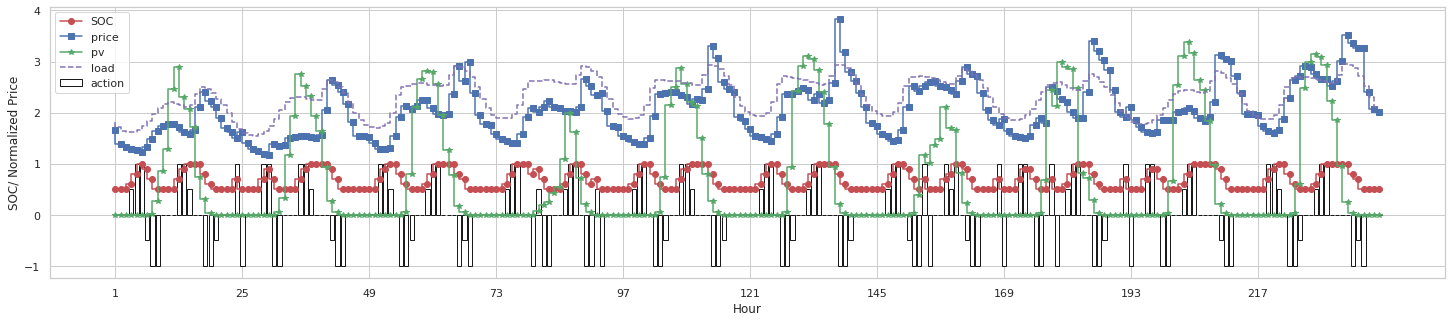

In [0]:
# First 10 days
start_idx = 0
end_idx = 240
get_resultplot(SOC_list, action_list, x, start_idx, end_idx)

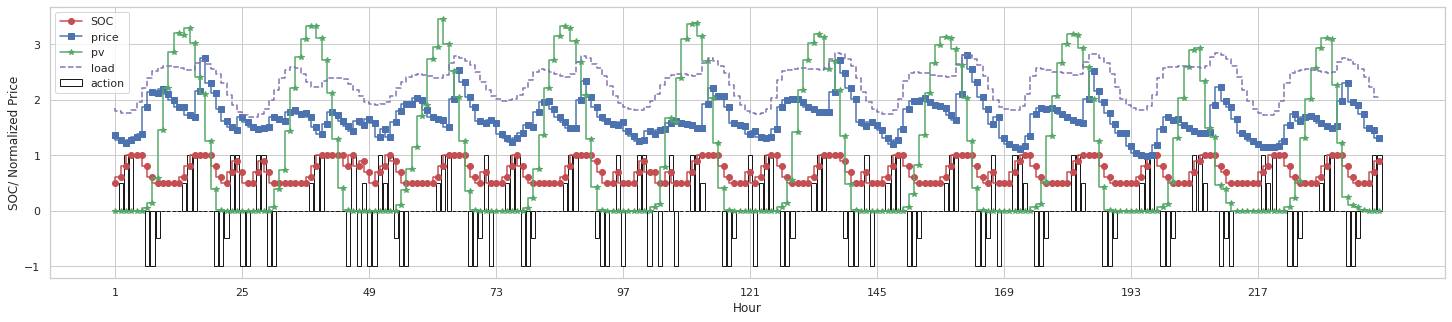

In [0]:
# Second last ten days
start_idx = -480
end_idx = -240
get_resultplot(SOC_list, action_list, x, start_idx, end_idx)

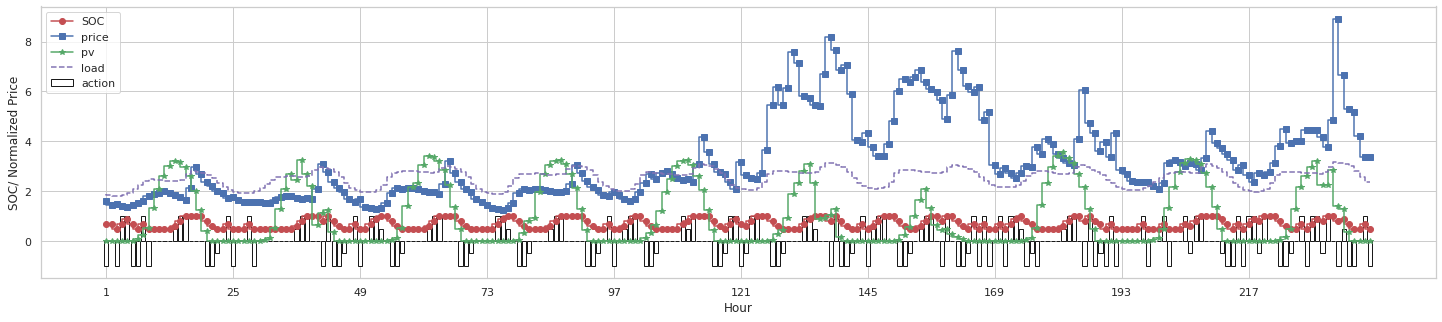

In [0]:
# Second last ten days
start_idx = len(SOC_list) - 240
end_idx = len(SOC_list)
get_resultplot(SOC_list, action_list, x, start_idx, end_idx)

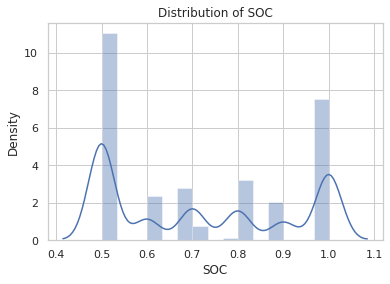

The probability of SOC smaller than target SOC is: 0.00%


In [0]:
sns.distplot(np.array(SOC_list), hist = True, norm_hist = True)
plt.ylabel("Density")
plt.xlabel("SOC")
plt.title("Distribution of SOC")
plt.show()

print("The probability of SOC smaller than target SOC is: {:.2f}%".format(np.sum(np.array(SOC_list) < 0.5) / len(SOC_list) * 100))

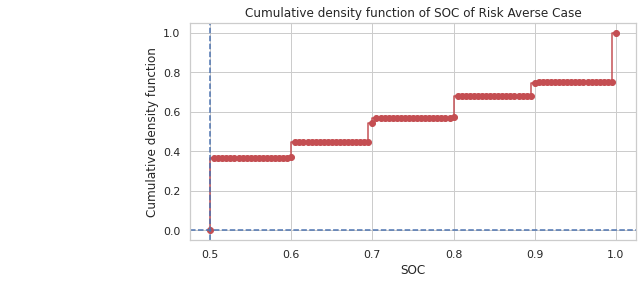

In [0]:
hist, bin_edges = np.histogram(np.array(SOC_list), bins = 100, density = True)
cum_prob = np.hstack((np.array([0]), np.cumsum(hist * np.diff(bin_edges)) / np.sum(hist * np.diff(bin_edges))))
target_SOC = battery.target_SOC
cum_prob_target = cum_prob[np.argmax(bin_edges >= target_SOC)]

plt.figure(figsize=(8, 4))
plt.step(bin_edges, cum_prob, "r-o")
plt.axvline(x  = target_SOC, linestyle = "--")
plt.axhline(y  = cum_prob_target, linestyle = "--")
plt.annotate("({}, {:.4f})".format(target_SOC, float(cum_prob_target)), 
             xy=(target_SOC - 0.25, cum_prob_target + 0.08))
plt.title("Cumulative density function of SOC of Risk Averse Case")
plt.xlabel("SOC")
plt.ylabel("Cumulative density function")
plt.show()

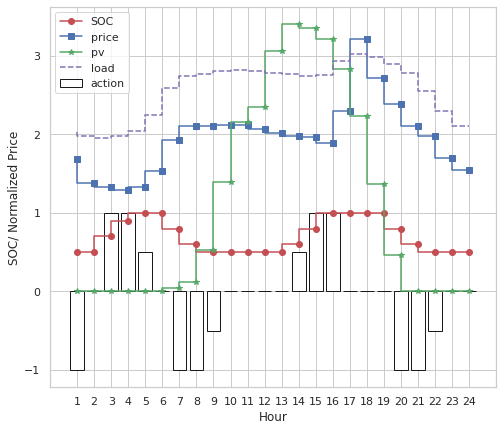

In [0]:
# Case 1 - Charged with PV not with grid to contain excess PV even the price is higher than average
# Use the spare capacity to store PV
# Not below the target SOC
start_idx = len(SOC_list) - 192
end_idx = len(SOC_list) - 168
get_resultplot(SOC_list, action_list, x, start_idx, end_idx)

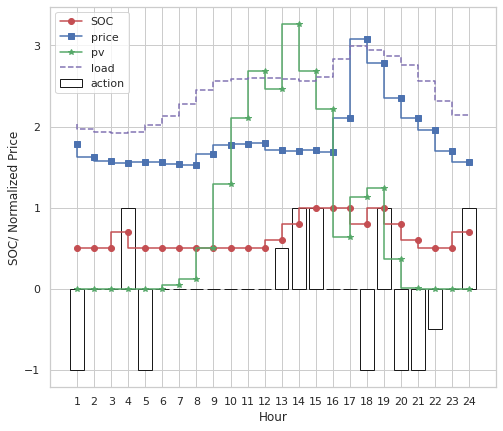

In [0]:
# Case 2 - Does not charge anymore when it is full
# When the price is not fluctuating
start_idx = len(SOC_list) - 216
end_idx = len(SOC_list) - 192
get_resultplot(SOC_list, action_list, x, start_idx, end_idx)

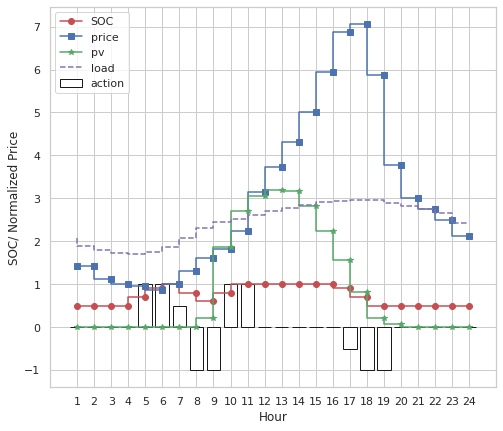

In [0]:
# Case 3 - Extremely high price
# Discharge even the pv is higher than local load
# Go below target SOC
start_idx = 13079
end_idx = 13103
get_resultplot(SOC_list, action_list, x, start_idx, end_idx)

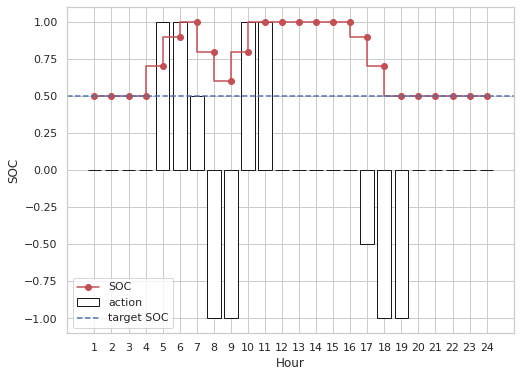

In [0]:
# Zoom of case 3

fig, ax = plt.subplots(1, 1, figsize = (8,6))
#ax2 = ax.twinx()
ln1 = ax.step(range(0, 24), SOC_list[13079:13103], "ro-", label = "SOC")
ln2 = ax.bar(range(0, 24), action_list[13079:13103], 
             facecolor = "w", edgecolor = "k", label = "action")
ln3 = ax.axhline(y  = 0.5, linestyle = "--", label = "target SOC")
ax.set_xlabel("Hour")
ax.set_ylabel("SOC")
lns = ln1 + [ln2] + [ln3]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 3)
plt.xticks(range(0, 24), range(1, 25))
plt.show()